In [18]:
import pandas as pd
load_subreddit = "leagueoflegends"
load_num_posts = 1312
load_num_days = 60
min_score = 5
min_comments = 2
comments_df = pd.read_csv(f'./data/{load_subreddit}_comments_{load_num_posts}_{load_num_days}_{min_score}_{min_comments}.csv', delimiter=';', header=0)

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
comments_df.shape

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(101413, 6)

In [20]:
import re
import nltk
from nltk import word_tokenize

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
def clean_comment(comment, stop_words, lemmatizer):
    """
    Description:
        We clean the comment by removing comment quotes, URLS, punctuation, 
        and discarding tokens that are not alphanumeric. We don't include words which are
        stopwords in english
        
    Input:
        comment: a raw comment text string
        stop_words: a set of stop words to be eliminated
        lemmatizer: a function with a method to lemmatize text
    
    Output:
        clean_comment: an array of token representing the clean comment ready to be used in a corpus 
    """
    
    if isinstance(comment, str):
        # remove comment quotes
        comment = re.sub(r'^>(.*?)\n$', '', comment, flags=re.M)

        # replace URLs with token
        comment = re.sub(r'https*://\S*', '', comment)

        # remove punctuation
        comment = re.sub(r'[.,!?;$]+', '', comment)
    else:
        return []
    
    comment_tokens = nltk.word_tokenize(comment)
    clean_comment = [ch.lower() for ch in comment_tokens 
                     if ch.isalpha() and
                     ch.lower() not in stop_words 
                     and len(ch) > 1
                    ]
    clean_comment = [lemmatizer.lemmatize(word) for word in clean_comment]
    return clean_comment

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Define lemmatizer and stop words
from nltk.stem.wordnet import WordNetLemmatizer
wnl = WordNetLemmatizer()

from gensim.parsing.preprocessing import STOPWORDS
en_stop = STOPWORDS.union(set(['like', 'savevideo']))

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
post_to_comments_dict = {}
all_comments = []
post_ids = comments_df['link_id'].unique()

for post_id in post_ids:
    comments = []
    # clean comments
    comments_raw = comments_df[comments_df['link_id'] == post_id]['body']
    for comment in comments_raw:
        comments.extend(clean_comment(comment, en_stop, wnl))
    all_comments.extend(comments)
    post_to_comments_dict[post_id] = comments
    
len(all_comments)

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1348975

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Common Words:  [('game', 20726), ('play', 10813), ('people', 10274), ('time', 8482), ('think', 8427), ('good', 8154), ('item', 7985), ('team', 7556), ('player', 7536), ('champion', 7089)]


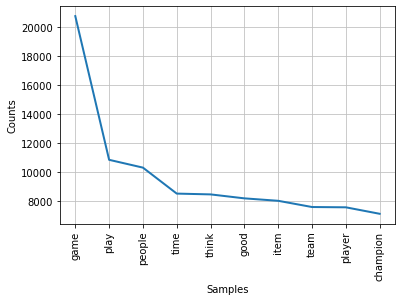

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [24]:
from nltk.probability import FreqDist
fdist = FreqDist(all_comments)
common_words = fdist.most_common(10)
print("\nCommon Words: ", common_words)
fdist.plot(10)

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


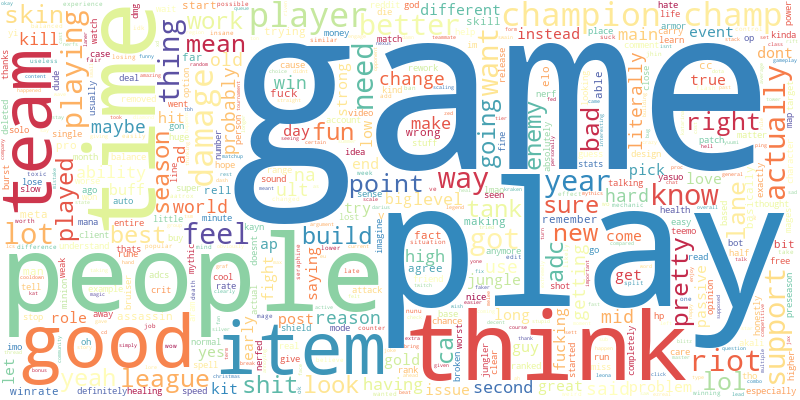

In [25]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=800, height=400, colormap="Spectral", max_words=500)
wordcloud.generate_from_frequencies(fdist)
wordcloud.to_image()

In [26]:
import gensim
# Create a list of post comment lists
post_to_comments_list = list(post_to_comments_dict.values())
dictionary = gensim.corpora.Dictionary(post_to_comments_list)
dictionary.filter_extremes(no_below=2, no_above=0.4, keep_n=100000)
bow_corpus = [dictionary.doc2bow(post) for post in post_to_comments_list]

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
from gensim.models import LdaMulticore
lda_model = LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=10, chunksize=100, random_state=100, workers=7)

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def plot_top_words(model, dictionary, num_topics, title, n_top_words=10):
    assert num_topics % 2 == 0, f'num_topics={num_topics} not divisible nicely by 2'
    assert num_topics // 2 < 7, f'num_topics={num_topics} is too high and will not display well'
    
    plot_cols = num_topics // 2
    
    fig, axes = plt.subplots(2, plot_cols, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    for topic_id in range(num_topics):
        topic_features = list()
        weights = list()
        
        for word_id, freq in lda_model.get_topic_terms(topic_id, n_top_words):
            topic_features.append(dictionary[word_id])
            weights.append(freq)
        
        ax = axes[topic_id]
        ax.barh(topic_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_id +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)  

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


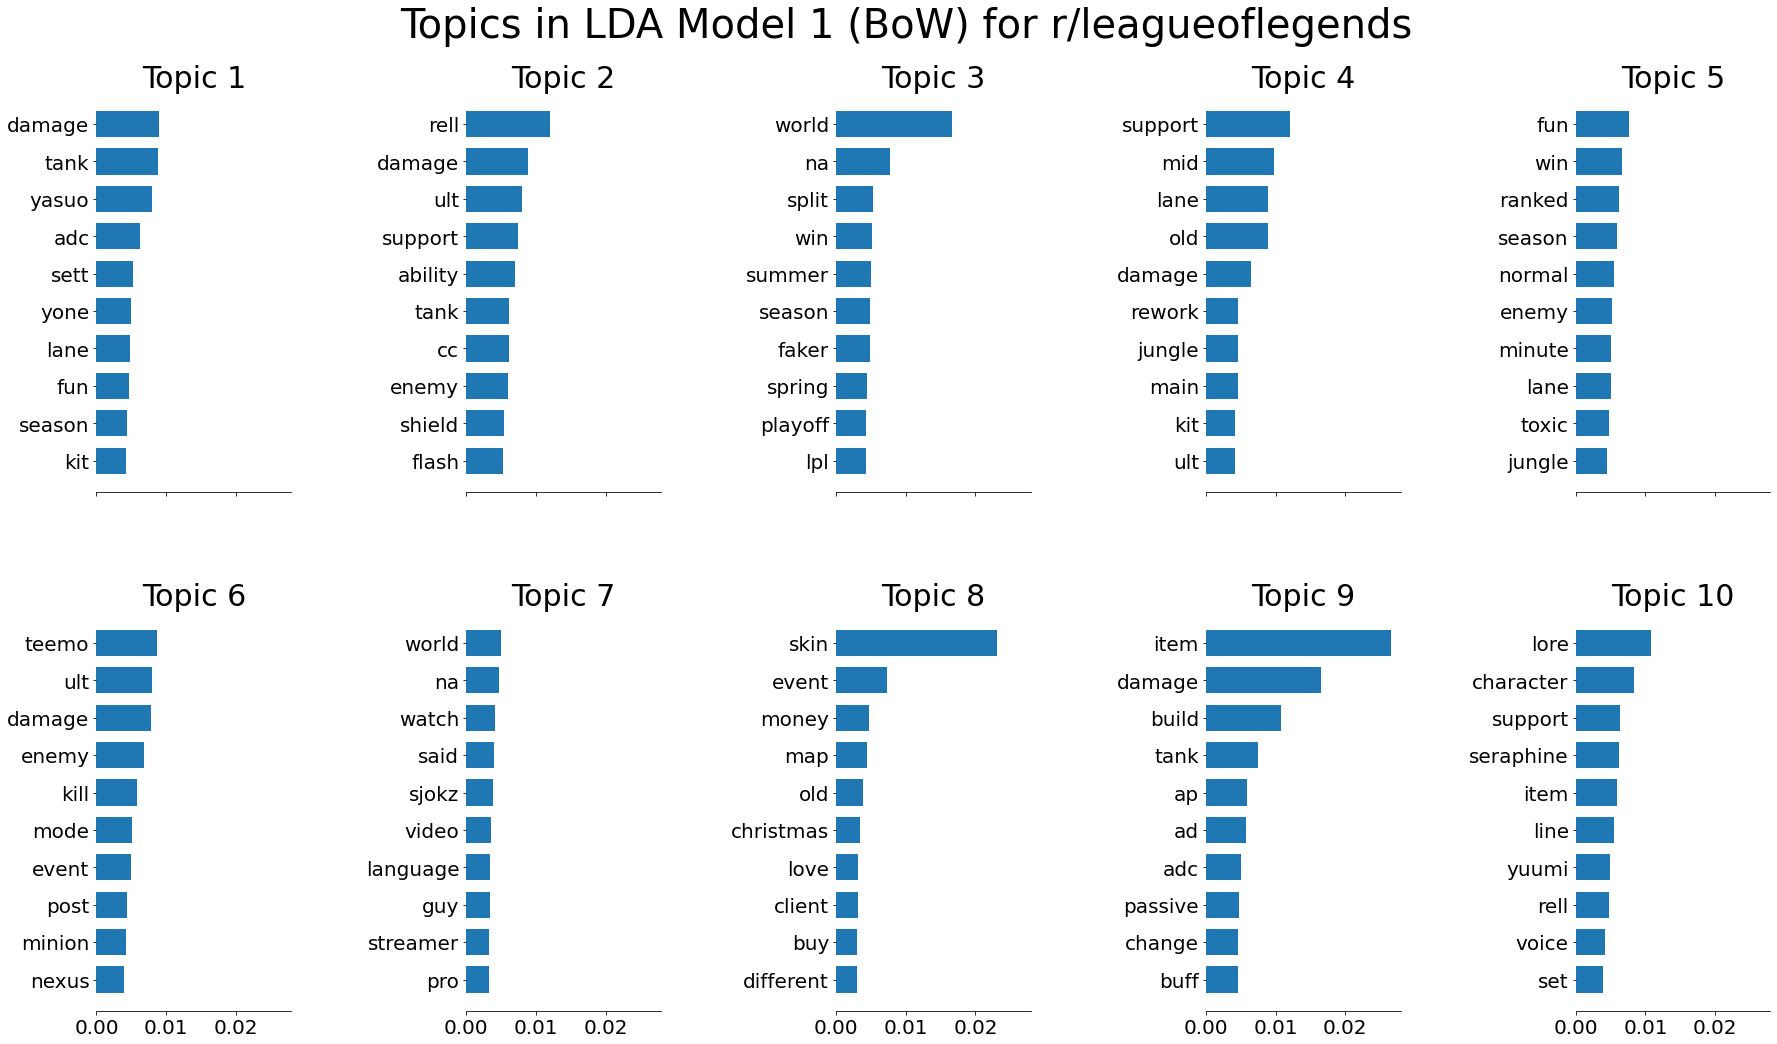

In [28]:
import matplotlib.pyplot as plt
plot_top_words(lda_model, dictionary, 10, f'Topics in LDA Model 1 (BoW) for r/{load_subreddit}')

In [15]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=post_to_comments_list, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3048706020232871


In [29]:
import pyLDAvis
from pyLDAvis import gensim as gensim_lda
LDAvis_prepared = gensim_lda.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.save_html(LDAvis_prepared, f'./output/LDA_{load_subreddit}.html')

C:\Users\mattp\anaconda3\envs\nlp_course\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
